# IS319 - Deep Learning

## TP2 - Dogs vs. cats (PyTorch)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the PyTorch library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [93]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [94]:
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image

PyTorch version: 2.1.0+cu118


## 1. Load and explore the dataset

In [95]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

File ‘/tmp/cats_and_dogs_filtered.zip’ already there; not retrieving.
Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.479.jpg', 'cat.274.jpg', 'cat.37.jpg', 'cat.588.jpg', 'cat.342.jpg', 'cat.755.jpg', 'cat.461.jpg', 'cat.902.jpg', 'cat.958.jpg', 'cat.523.jpg']
['dog.981.jpg', 'dog.447.jpg', 'dog.280.jpg', 'dog.336.jpg', 'dog.928.jpg', 'dog.43.jpg', 'dog.213.jpg', 'dog.466.jpg', 'dog.739.jpg', 'dog.805.jpg']


**(Question)** Display some images of cats and dogs from the train set and the validation set.

In [96]:
# YOUR CODE HERE
valid_cat_fnames = os.listdir(valid_cats_dir)
print(valid_cat_fnames[:10])
valid_dog_fnames = os.listdir(valid_dogs_dir)
print(valid_dog_fnames[:10])

['cat.2171.jpg', 'cat.2045.jpg', 'cat.2153.jpg', 'cat.2477.jpg', 'cat.2433.jpg', 'cat.2324.jpg', 'cat.2284.jpg', 'cat.2217.jpg', 'cat.2498.jpg', 'cat.2034.jpg']
['dog.2262.jpg', 'dog.2004.jpg', 'dog.2485.jpg', 'dog.2464.jpg', 'dog.2308.jpg', 'dog.2312.jpg', 'dog.2267.jpg', 'dog.2290.jpg', 'dog.2130.jpg', 'dog.2474.jpg']


Text(0.5, 1.0, 'valid dog example')

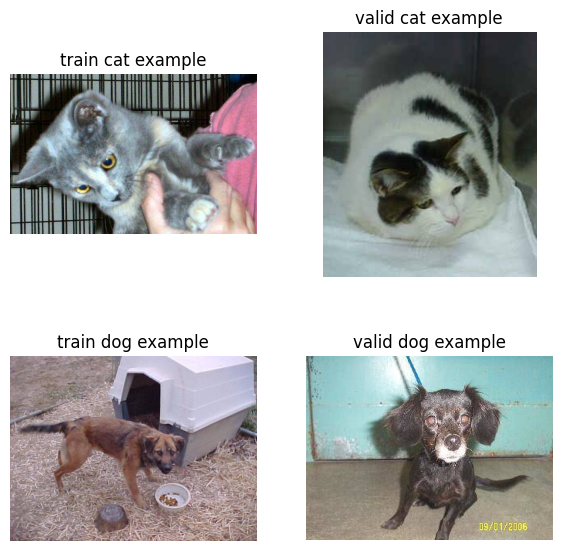

In [97]:
from PIL import Image

fig = plt.figure(figsize=(7, 7))

# setting values to rows and column variables
rows, columns = 2, 2

# reading images
train_cat = Image.open(train_cats_dir + '/cat.980.jpg')
valid_cat = Image.open(valid_cats_dir + '/cat.2205.jpg')
train_dog = Image.open(train_dogs_dir + '/dog.542.jpg')
valid_dog = Image.open(valid_dogs_dir + '/dog.2024.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(train_cat)
plt.axis('off')
plt.title("train cat example")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(valid_cat)
plt.axis('off')
plt.title("valid cat example")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(train_dog)
plt.axis('off')
plt.title("train dog example")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(valid_dog)
plt.axis('off')
plt.title("valid dog example")

## 2. Prepare the dataset

**(Question)** Following the documentation, create a custom `torch.utils.data.Dataset` class to handle your train and validation datasets. Allow this class to resize images and normalize them. Then, create a `DataLoader` for train and validation datasets to handle shuffling and batches.

In [98]:
# YOUR CODE HERE
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

#Our customized Dataset class

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.image_paths = [] # We store here the paths to the images
        self.labels = []  # We store here the labels in string format "dogs/cats"

        class_names = os.listdir(data_path)

        for c in class_names:
            class_path = os.path.join(data_path, c)
            images_names = os.listdir(class_path)
            for i in images_names:
                image_path = os.path.join(class_path, i)
                self.image_paths.append(image_path)
                self.labels.append(image_path.split('/')[-2])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        label = self.labels[idx]
        label = 0 if (label=="cats") else 1 #Here we quantify the labels

        if self.transform is not None:
            image = self.transform(image)
        return image, label


#Transform object

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Values ???
])


# Datasets

train_dataset = ImageDataset(train_dir, transform=transform)
test_dataset = ImageDataset(valid_dir, transform=transform)


In [99]:
#DataLoaders

BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show the model and its number of parameters.

In [100]:
# YOUR CODE HERE

# This is the best architecture we could design so far in terms of generalization
class ConvNeuralNet(nn.Module):
    def __init__(self, batch_norm = False):
        self.batch_norm = batch_norm
        super(ConvNeuralNet, self).__init__()

        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)

        self.batch_norm1 = nn.BatchNorm2d(32)

        self.relu1 = nn.ReLU()


        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        self.batch_norm2 = nn.BatchNorm2d(64)

        self.relu2 = nn.ReLU()


        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.fc1 = nn.Linear(238144, 128)

        self.batch_norm3 = nn.BatchNorm1d(128)

        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 32)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        if(self.batch_norm):
          out = self.batch_norm1(out)
        out = self.relu1(out)

        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        if(self.batch_norm):
          out = self.batch_norm2(out)

        out = self.relu2(out)

        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        if(self.batch_norm):
          out = self.batch_norm3(out)
        out = self.relu3(out)
        out = self.fc2(out)
        out = self.relu4(out)
        out = self.fc3(out)

        out = self.sigmoid(out)


        return out




In [101]:
# Setting our needed variables
learning_rate = 0.01
num_epochs = 15
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [102]:
# Preparing the model for training

model = ConvNeuralNet()

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

# optimizer = torch.optim.Adam(model.parameters())

total_step = len(train_loader)

**(Question)** Using PyTorch, implement a training loop with your model and an appropriate loss function.

In [103]:
# YOUR CODE HERE

# A function that trains a model

def train(model, loader, optimizer, criterion, device=device, num_epochs=num_epochs,):
  model.to(device)
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(loader):
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          # labels = labels.unsqueeze(1)
          outputs = outputs.squeeze(1)
          labels = labels.float()
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
  model.to('cpu')

**(Question)** Train your model. Monitor train and validation accuracy. Analyze your results.

In [104]:
# YOUR CODE HERE

train(model, train_loader, optimizer, criterion)

Epoch [1/15], Loss: 0.6640
Epoch [2/15], Loss: 0.6620
Epoch [3/15], Loss: 0.6860
Epoch [4/15], Loss: 0.6835
Epoch [5/15], Loss: 0.6157
Epoch [6/15], Loss: 0.7087
Epoch [7/15], Loss: 0.6148
Epoch [8/15], Loss: 0.5941
Epoch [9/15], Loss: 0.5038
Epoch [10/15], Loss: 0.3850
Epoch [11/15], Loss: 0.1911
Epoch [12/15], Loss: 0.3003
Epoch [13/15], Loss: 0.1323
Epoch [14/15], Loss: 0.0953
Epoch [15/15], Loss: 0.1478


In [105]:
# A function that tests a model on a data loader and returns the accuracy

def test(model, loader, device=device):
  model.to(device)
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          labels = labels
          outputs = outputs.squeeze()
          outputs = (outputs >= 0.5).float()

          equal_elements = (outputs == labels)
          correct_n = equal_elements.sum().item()
          total += labels.size(0)
          correct += correct_n

      return correct/total


In [106]:
train_acc = test(model, train_loader)

print("Train Acurracy = " + str(train_acc))


Train Acurracy = 0.964


In [107]:
test_acc = test(model, test_loader)

print("Test Acurracy = " + str(test_acc))

Test Acurracy = 0.655


We noticed that our model has the following accuracy values (last execution) :
- Train Accuracy : 0.964
- Test Accuracy : 0.655

Our model might be overfitting as it has a very high accuracy on the training set and a very average accuracy on the testing set

**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe?

After using the GPU provided by google's Backend on Colab, we noticed a very great speed up compared to the case where we used our laptop's CPU. (Nearly 10 times faster)


## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [108]:
# YOUR CODE HERE

#  Augment Data
from torch.utils.data import ConcatDataset

def Augment_data(data_path, shuffle=True):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)], p=0.5),
        # transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
        transforms.ToTensor(),
    ])

    augmented_data = ImageDataset(data_path, transform)

    return augmented_data

# The augmented training dataset :

aug_dataset = Augment_data(train_dir)
new_train_dataset = ConcatDataset([train_dataset, aug_dataset])

new_train_loader = DataLoader(dataset=new_train_dataset, batch_size=BATCH_SIZE, shuffle=True)





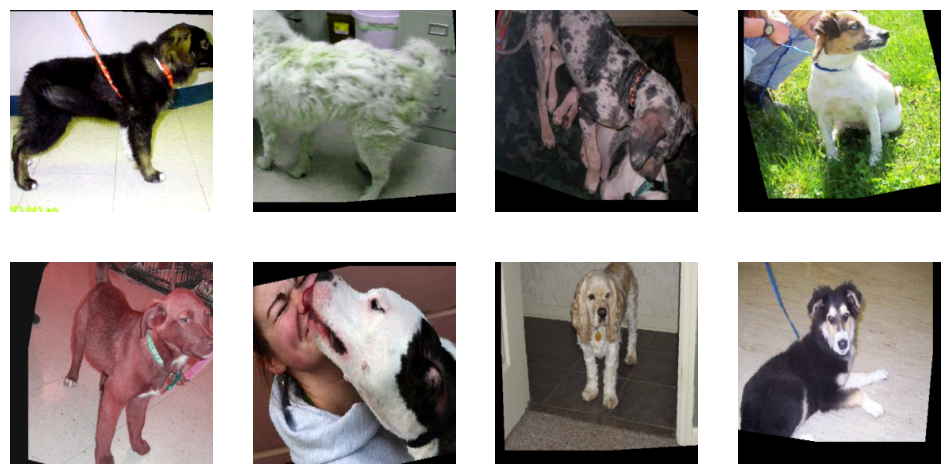

In [109]:
visualisation_loader = DataLoader(dataset=aug_dataset, batch_size=BATCH_SIZE)

batch_iter = iter(visualisation_loader)

batch = next(batch_iter)

images, labels = batch
four_images = images[:8]
eight_images_np = four_images.numpy()

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(8):
    row, col = divmod(i, 4)

    image_np = np.transpose(eight_images_np[i], (1, 2, 0))  # Channels-last format for matplotlib
    axes[row, col].imshow(image_np)
    axes[row, col].axis('off')  # Turn off axis labels

plt.show()



The strategies we used in this section are :
- Data Augmentation: by applying multiple operations (Flips, rotations, Resizing, Color changes ..) with the torch transform object. We then merged the original images with the modified ones, to form a larger new dataset (2 times larger)
- Batch normalization : we added batch 3 normalization layers :
      
    *    after the second convulotional layer and before the activation function

    *    after the fourth convulotional layer and before the activation function

    *    after the first linear layer and before the activation function



In [110]:
# YOUR CODE HERE

# Here we add batch normalization (2 conv layers and 1 linear layer)
model2 = ConvNeuralNet(batch_norm=True)

criterion2 = nn.BCELoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
# optimizer2 = torch.optim.Adam(model2.parameters())

**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model.

In [111]:
# YOUR CODE HERE

train(model2, new_train_loader, optimizer=optimizer2, criterion=criterion2)


Epoch [1/15], Loss: 0.6538
Epoch [2/15], Loss: 0.7012
Epoch [3/15], Loss: 0.7659
Epoch [4/15], Loss: 0.6330
Epoch [5/15], Loss: 0.5336
Epoch [6/15], Loss: 0.3595
Epoch [7/15], Loss: 0.3452
Epoch [8/15], Loss: 0.4103
Epoch [9/15], Loss: 0.2015
Epoch [10/15], Loss: 0.3441
Epoch [11/15], Loss: 0.2522
Epoch [12/15], Loss: 0.4703
Epoch [13/15], Loss: 0.2551
Epoch [14/15], Loss: 0.2270
Epoch [15/15], Loss: 0.3470


In [112]:
train_acc = test(model2, new_train_loader)
print("Train Acurracy = " + str(train_acc))

Train Acurracy = 0.8525


In [113]:
test_acc = test(model2, test_loader)
print("Test Acurracy = " + str(test_acc))

Test Acurracy = 0.724


After applying the strategies mentioned above, we noticed a big improvement in our model's performance on the testing dataset.
The strategies helped reduce overfitting since the train accuracy dropped moderately.

New accuracies (last execution):
- Train Accuracy : 0.8525
- Test Accuracy : 0.724

Conclusion : The strategies we used enhanced the generalization of our model

## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [114]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

#Here we take only the feature extraction layers of vgg16


vgg_features = nn.Sequential(*list(vgg16.features.children()))#There are 6 fully connected layers in VGG16

vgg_features.eval()

#Here we freeze the parameters of the feature extraction layers
for param in vgg_features.parameters():
    param.requires_grad = False



**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [115]:
# YOUR CODE HERE
class CustomVgg16(nn.Module):
    def __init__(self, feature_extractor):
        super(CustomVgg16, self).__init__()

        #Here we plug the feature extractor of Vgg16 in our new model
        self.features = feature_extractor


        #Here we define our own linear layers

        self.MLP = nn.Sequential(
        nn.Linear(32768 , 256),
        nn.ReLU(),
        nn.Linear(256, 32),
        nn.ReLU(),
        nn.Linear(32, 1),
        nn.Sigmoid())

    def forward(self, x):

        out = self.features(x)

        out = out.reshape(out.size(0), -1)

        out = self.MLP(out)


        return out

**(Question)** Train your model. Analyze your results and compare with your initial model trained from scratch.

In [116]:
# YOUR CODE HERE

learning_rate = 0.01
custom_vgg = CustomVgg16(vgg_features)

criterion3 = nn.BCELoss()
optimizer3 = torch.optim.SGD(custom_vgg.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
# optimizer3 = torch.optim.Adam(model2.parameters())
# Training :

train(custom_vgg, train_loader, optimizer=optimizer3, criterion=criterion3, num_epochs=10)

Epoch [1/10], Loss: 0.5225
Epoch [2/10], Loss: 0.0102
Epoch [3/10], Loss: 0.0003
Epoch [4/10], Loss: 0.0001
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0013
Epoch [7/10], Loss: 0.0013
Epoch [8/10], Loss: 0.0002
Epoch [9/10], Loss: 0.0001
Epoch [10/10], Loss: 0.0001


In [117]:
train_acc = test(custom_vgg, train_loader)
print("Training accuracy : " + str(train_acc))

Training accuracy : 1.0


In [118]:
test_acc = test(custom_vgg, test_loader)
print("Testing accuracy : " + str(test_acc))

Testing accuracy : 0.994


We noticed that the the loss of the first epoch started at a very low value compared to our first two models. This proves that the features extraction layers of Vgg16 are very well trained, and in particular, on cats & dogs pictures.

Using Vgg16's feature extractor increased the train accuracy to 1.0, and the test accuracy to 0.994. We conclude by this that despite the overfitting of our custom vgg on the train dataset, it still manages to classify correctly 99.4% of the test dataset. This can be explained by the following :

- <The VGG16 model can achieve a test accuracy of 92.7% in ImageNet, a dataset containing more than 14 million training images across 1000 object classes.>
(According to Datagen)

Conclusion : The custom Vgg16 model outperforms our first model and outpeforms our enhanced model (second model).


